In [ ]:
import os
import pickle
import numpy as np
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import BinaryAccuracy
from torchmetrics import AUROC
import timm
import matplotlib.pyplot as plt
import cv2

In [ ]:
num_classes = 1
batch_size = 32
batch_size_test = 32
pretrained = True

resnetbit_model = 'resnetv2_50x1_bit.goog_in21k'

dataset_path = "HH25_256"
train_set_path = os.path.join(dataset_path, 'training')
validation_set_path = os.path.join(dataset_path, 'testing')
test_set_path = os.path.join(dataset_path, 'validation')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_grayscale_model(model_name, pretrained=True, num_classes=1, device=None):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    first_conv_layer = None

    if hasattr(model, 'stem'):
        # If the model has a stem attribute, look for the first Conv2d layer there.
        for layer in model.stem.modules():
            if isinstance(layer, nn.Conv2d) and layer.in_channels == 3:
                first_conv_layer = layer
                break
    elif hasattr(model, 'conv1'):
        # If the model has a 'conv1' attribute, assume it’s the first Conv2d layer.
        first_conv_layer = model.conv1
    elif hasattr(model, 'features') and isinstance(model.features, nn.Sequential):
        # For VGG and similar models that use a Sequential container for features
        for layer in model.features:
            if isinstance(layer, nn.Conv2d) and layer.in_channels == 3:
                first_conv_layer = layer
                break
    elif hasattr(model, 'Conv2d_1a_3x3'):
        # For models with Conv2d_1a_3x3 like Inception or others in timm
        first_conv_layer = model.Conv2d_1a_3x3.conv
    elif hasattr(model, 'conv_stem'):
        # New case for models like MobileNetV3 or EfficientNet with conv_stem
        first_conv_layer = model.conv_stem


    if first_conv_layer is not None:
        # Create a new Conv2d layer with 1 input channel for grayscale
        new_first_conv = nn.Conv2d(
            in_channels=1,
            out_channels=first_conv_layer.out_channels,
            kernel_size=first_conv_layer.kernel_size,
            stride=first_conv_layer.stride,
            padding=first_conv_layer.padding,
            bias=first_conv_layer.bias is not None
        )

        # Copy pretrained weights by averaging over the RGB channels
        with torch.no_grad():
            new_first_conv.weight[:] = first_conv_layer.weight.mean(dim=1, keepdim=True)

        # Replace the first convolutional layer with the new grayscale-compatible layer
        first_conv_layer.in_channels = 1
        first_conv_layer.weight = new_first_conv.weight
        if first_conv_layer.bias is not None:
            first_conv_layer.bias = new_first_conv.bias

    else:
        raise ValueError(f"No suitable first convolutional layer found for model {model_name}.")
    return model


# configure dataset
class CustomDataset(Dataset):
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        # image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(int(data_point['label'] == 1), dtype=torch.float)
        additional_info = data_point['additional_info']
        return image, label, additional_info


# create model and dataset, dataloader
models = [create_grayscale_model(model, pretrained=pretrained, num_classes=num_classes).to(device) for model in [resnetbit_model]]
model_names = ['resnetbit']

dataset_train = CustomDataset(train_set_path)
dataset_validation = CustomDataset(validation_set_path)
dataset_test = CustomDataset(test_set_path)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size_test, shuffle=False, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, drop_last=False)

In [3]:
# Load the saved model
# model_path = 'resnetbit_fold5.pt'
model_path = 'resnetbit_early_stopping_unsharped_mask_zoomed.pt'
state_dict = torch.load(model_path, map_location=device)
models[0].load_state_dict(state_dict)
models[0].eval()

C:\Users\William\AppData\Local\Temp\ipykernel_160544\470090498.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3)

In [4]:
def validate(dataloader_validation, model, loss_fn, device):
    model.eval()

    running_loss = 0.0
    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task = 'binary')  # For binary classification AUC

    with torch.no_grad():
        for (images, labels, _) in dataloader_validation:
            images, labels = images.to(device), labels.to(device)

            prediction = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
            loss = loss_fn(prediction, labels)

            running_loss += loss.item()

            accuracy_metric.update(prediction, labels)
            auc_metric.update(prediction, labels)

    loss_of_epoch = running_loss / len(dataloader_validation)
    accuracy = accuracy_metric.compute().item()
    auc_score = auc_metric.compute().item()  # Compute AUC after all batches

    print(f'Val Loss: {loss_of_epoch:.4f} \t Val Accuracy: {accuracy:.3f} \t Val AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        # Hook to capture gradients from the target layer
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # Save the output feature map from the target layer
        self.feature_maps = output

    def backward_hook(self, module, grad_in, grad_out):
        # Save the gradient from the target layer
        self.gradients = grad_out[0]

    def __call__(self, input_image, class_idx=None):
        self.model.eval()
        input_image = input_image.unsqueeze(0)

        # Forward pass
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax().item()

        # Backward pass for the given class index
        self.model.zero_grad() 
        target = output[:, class_idx]
        target.backward()

        # Convert to CPU and NumPy arrays
        gradients = self.gradients.cpu().data.numpy()[0]
        feature_maps = self.feature_maps.cpu().data.numpy()[0]

        # Compute the Grad-CAM weighted sum
        weights = np.mean(gradients, axis=(1, 2))
        grad_cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * feature_maps[i]

        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, (input_image.size(2), input_image.size(3)))
        grad_cam = grad_cam - grad_cam.min()
        grad_cam = grad_cam / grad_cam.max()
        return grad_cam

c:\Users\William\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


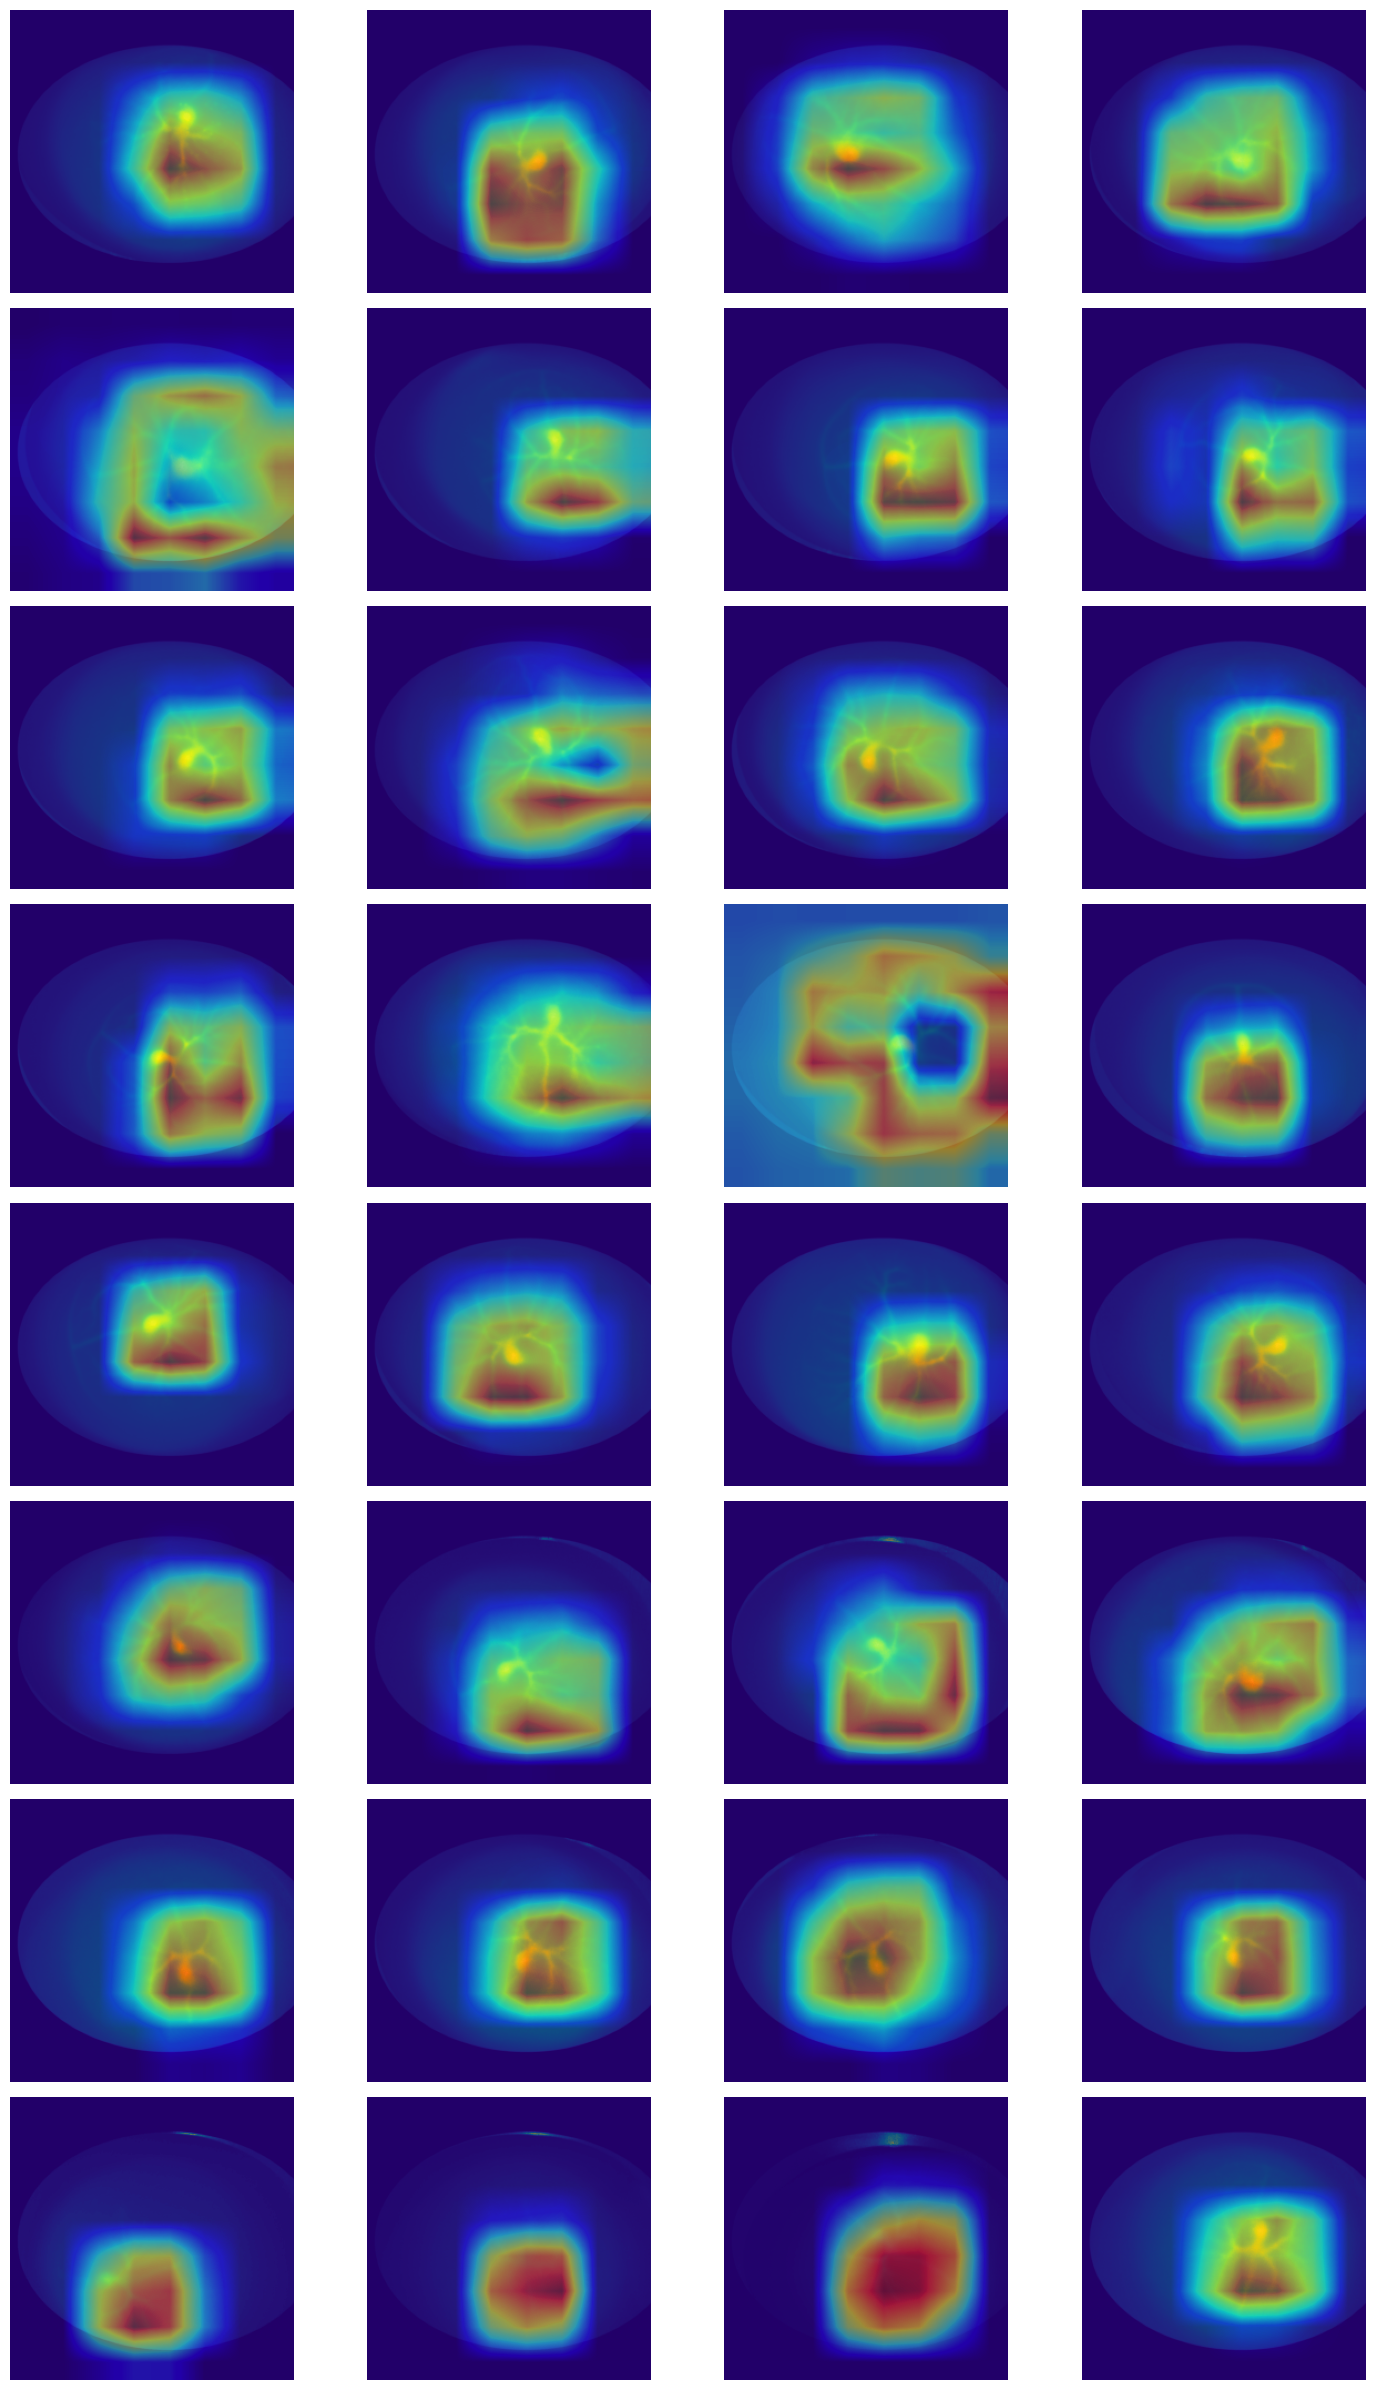

In [27]:
def visualize_heatmap(model, dataloader_test, device):
    model = model.to(device)
    rows = 8
    fig, axes = plt.subplots(rows, 4, figsize=(15, rows * 3))
    axes = axes.flatten()
    axes_idx = 0
    conv3_layers = [layer for name, layer in model.named_modules() if name.endswith('conv3')]
    conv3_layer = conv3_layers[-1]

    iterator = iter(dataloader_test)
    next(iterator)
    next(iterator)
    next(iterator)
    images, labels, additional_info = next(iterator)

    for i in range(len(images)):
        image = images[i].to(device)

        conv3_layers = [layer for name, layer in model.named_modules() if name.endswith('conv3')]
        conv3_layer = conv3_layers[-1]

        grad_cam = GradCAM(model, conv3_layer)
        heatmap = grad_cam(image)

        image_np = image.cpu().numpy().transpose(1, 2, 0)
        image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)

        axes[axes_idx].imshow(image_np, alpha=1)
        axes[axes_idx].imshow(heatmap, cmap='jet', alpha=0.5)
        axes[axes_idx].axis('off')
        axes_idx+=1

    for j in range(axes_idx, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the visualization function with the model and dataloader
visualize_heatmap(models[0], dataloader_test, device)

In [28]:
model = models[0]
model.eval()
torch.set_printoptions(sci_mode=False)

# Find the confident predictions
with torch.no_grad():
    for (images, labels, _) in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        prediction = model(images).sigmoid().squeeze(1)
        print(torch.nonzero(abs(prediction - labels) < 0.2, as_tuple=True)[0])

tensor([ 7, 10, 15, 17, 18, 19, 30], device='cuda:0')
tensor([ 0,  3, 12, 13, 14, 16], device='cuda:0')
tensor([ 7, 31], device='cuda:0')
tensor([4], device='cuda:0')
tensor([], device='cuda:0', dtype=torch.int64)
tensor([0], device='cuda:0')
